# Explore the construction events in Batch 1

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

tqdm.pandas()

In [2]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [3]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

# * Assessor parcel data
assessor_parcels = gpd.read_file(os.path.join(INPUT_FP, 'AssessorData', 'assessor_scc_parcels.geojson'))
sj_assessor_parcels = assessor_parcels.loc[assessor_parcels['SITUS_CITY'] == 'SAN JOSE'].copy()
del assessor_parcels

# Keep only parcel data
sj_assessor_parcels = sj_assessor_parcels.loc[sj_assessor_parcels['FEATURE'] == 'PAR']
sj_assessor_parcels = sj_assessor_parcels[[
    'OBJECTID', 'APN', 'LAND', 'IMPROVEMEN', 'geometry']].copy()

In [4]:
x = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=5)

In [8]:
cbg_income_2016_SJ['median_inc'].describe()

count       641.000000
mean      99708.164601
std       42069.049869
min       13975.000000
25%       68375.000000
50%       96630.000000
75%      125048.000000
max      250001.000000
Name: median_inc, dtype: float64

In [6]:
x.unique()

[(105625.0, 132330.0], (62880.0, 85156.0], (132330.0, 250001.0], (85156.0, 105625.0], (13974.999, 62880.0], NaN]
Categories (5, interval[float64, right]): [(13974.999, 62880.0] < (62880.0, 85156.0] < (85156.0, 105625.0] < (105625.0, 132330.0] < (132330.0, 250001.0]]

In [4]:
# * Historical Assessor data (2016 reported 2018)
assessor_historical = pd.read_csv(
    '/oak/stanford/groups/deho/corelogic/data/final/CA/SC_county_2018_Tax.txt', 
    delimiter='|', low_memory=False)

In [5]:
# * Historical Assessor data (2014 reported 2016)
assessor_historical_14 = pd.read_csv(
    '/oak/stanford/groups/deho/corelogic/data/final/CA/SC_county_2016_Tax.txt', 
    delimiter='|', low_memory=False)

In [29]:
# Inputs from processing Batch 1
new_sbuild_2020 = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B1-100', 'permit-matching-apns-CF-min11-GT1.csv'), 
    dtype={'APN': str})

# Add CBG-income data
new_sbuild_2020_cbg = pd.merge(
    new_sbuild_2020, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

# * Generate quartile and neighborhood columns for each CBG
if 'neighborho' in cbg_income_2016_SJ.columns:
    cbg_income_2016_SJ.drop('neighborho', axis=1, inplace=True)

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

cbg_income_2016_SJ['quartile'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_names[quartile])
 
new_sbuild_2020_cbg = pd.merge(
    new_sbuild_2020_cbg, cbg_income_2016_SJ[['GEOID', 'median_inc', 'quartile']], 
    on='GEOID', how='left', validate='many_to_one')

## Parcel-level (using CBG income)

In [33]:
new_sbuild_parcel_perm = new_sbuild_2020_cbg.loc[new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0].copy()
new_sbuild_parcel_perm = new_sbuild_parcel_perm.loc[
    new_sbuild_parcel_perm.index.repeat(new_sbuild_parcel_perm.count_new_sbuild_permitted)]
new_sbuild_parcel_perm['Permitted'] = 1

new_sbuild_parcel_unperm = new_sbuild_2020_cbg.loc[new_sbuild_2020_cbg['count_new_sbuild_unpermitted'] > 0].copy()
new_sbuild_parcel_unperm = new_sbuild_parcel_unperm.loc[
    new_sbuild_parcel_unperm.index.repeat(new_sbuild_parcel_unperm.count_new_sbuild_unpermitted)]
new_sbuild_parcel_unperm['Permitted'] = 0

new_sbuild_parcel = pd.concat([new_sbuild_parcel_perm, new_sbuild_parcel_unperm])
new_sbuild_parcel = new_sbuild_parcel[['APN', 'GEOID', 'median_inc', 'quartile', 'Permitted']]

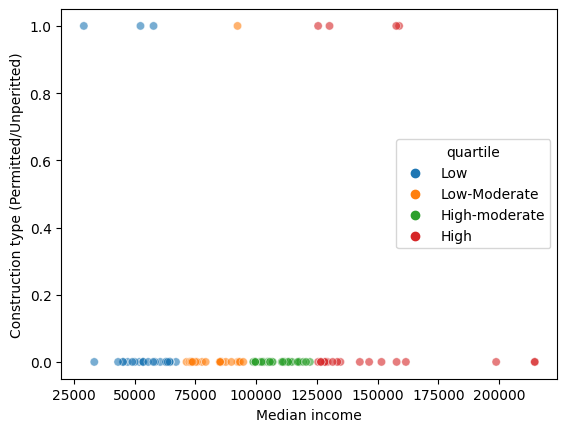

In [83]:
ax = sns.scatterplot(new_sbuild_parcel, x='median_inc', y='Permitted', hue='quartile', alpha=0.6)
ax.set(xlabel='Median income', ylabel='Construction type (Permitted/Unperitted)')
plt.show()

In [84]:
outcome = new_sbuild_parcel.groupby('quartile').agg(
    {'Permitted': 'sum', 'APN': 'count'}).reset_index()
outcome['permitted_prop'] = outcome['Permitted'] / outcome['APN']

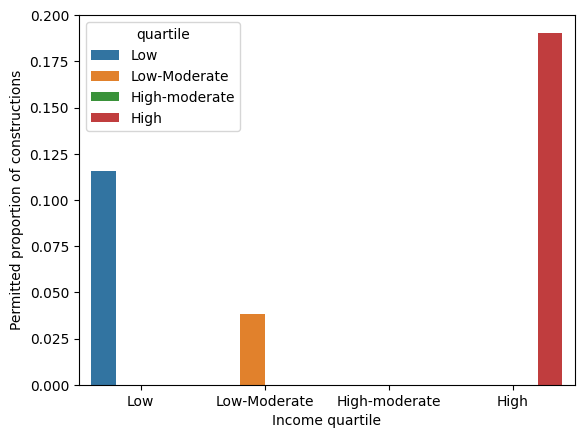

In [85]:
ax = sns.barplot(outcome, x='quartile', y='permitted_prop', hue='quartile')
ax.set(xlabel='Income quartile', ylabel='Permitted proportion of constructions')
plt.show()

In [86]:
# Bottom 3 quartiles vs High quartile

low = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'] != 'High']
high = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'] == 'High']
baseline = low['Permitted'].sum() / low['APN'].count() * 100
high_level = high['Permitted'].sum() / high['APN'].count() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 4.8; Effect size: 14.2


In [87]:
# Median

low = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'].isin(['Low', 'Low-Moderate'])]
high = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'].isin(['High-moderate', 'High'])]
baseline = low['Permitted'].sum() / low['APN'].count() * 100
high_level = high['Permitted'].sum() / high['APN'].count() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 7.7; Effect size: 0.0


In [88]:
# Bottom vs Upper quartiles

low = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'].isin(['Low'])]
high = new_sbuild_parcel.loc[new_sbuild_parcel['quartile'].isin(['High'])]
baseline = low['Permitted'].sum() / low['APN'].count() * 100
high_level = high['Permitted'].sum() / high['APN'].count() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 11.5; Effect size: 7.5


In [89]:
pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4).unique()

[(125048.0, 250001.0], (68375.0, 96630.0], (96630.0, 125048.0], (13974.999, 68375.0], NaN]
Categories (4, interval[float64, right]): [(13974.999, 68375.0] < (68375.0, 96630.0] < (96630.0, 125048.0] < (125048.0, 250001.0]]

## CBG-level

In [90]:
# Aggregate at the CBG level
new_sbuild_2020_cbg_agg = new_sbuild_2020_cbg.groupby('GEOID').agg(
    {'count_new_sbuild_permitted': 'sum', 'count_new_sbuild': 'sum', 'median_inc': 'mean', 'quartile': 'first'}).reset_index()
new_sbuild_2020_cbg_agg['perm_rate'] = new_sbuild_2020_cbg_agg[
    'count_new_sbuild_permitted'] / new_sbuild_2020_cbg_agg['count_new_sbuild']

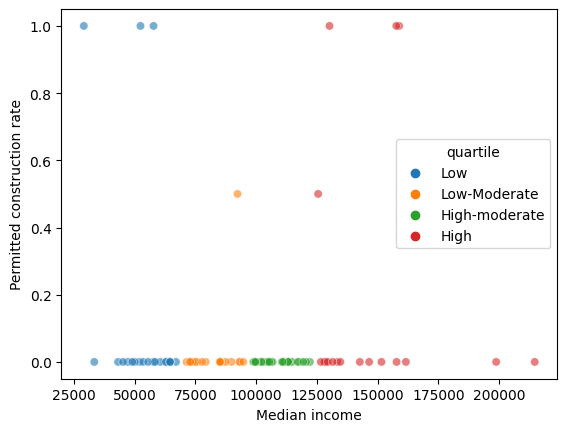

In [91]:
ax = sns.scatterplot(new_sbuild_2020_cbg_agg, x='median_inc', y='perm_rate', hue='quartile', alpha=0.6)
ax.set(xlabel='Median income', ylabel='Permitted construction rate')
plt.show()

## Low-income permitted events

In [92]:
new_sbuild_2020_cbg.loc[
    (new_sbuild_2020_cbg['quartile']!= 'High') & (new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0)]

,APN,count_new_sbuild,pcount_2015_20,count_new_sbuild_permitted,count_new_sbuild_unpermitted,GEOID,median_inc,quartile
11,26435035,1,1.0,1.0,0.0,060855017002,29054.054054,Low
13,26462005,2,1.0,1.0,1.0,060855023022,92308.000000,Low-Moderate
49,48605010,1,1.0,1.0,0.0,060855034012,52371.000000,Low
62,49724012,1,1.0,1.0,0.0,060855032045,57750.000000,Low


In [ ]:
#'26435035'  ok
# 26462005 OK 2nd unit added
# 48605010 seems to just be re-roofing: permit value is 0; sqft is 0
# 49724012 OK

In [80]:
permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(['49724012'])]

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
11962,E_45633,36673,36673,"2943 GARDEN AV 2 , SAN JOSE CA 95111",49724012,QSP CONSTRUCTION,QSP CONSTRUCTION,New Construction,2nd Unit Added,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,465.113276,11854.445748,POLYGON ((-121.84184262220663 37.2926805609769...,2018-06-11 00:00:00,2017,2018


## High-income permitted events

In [81]:
new_sbuild_2020_cbg.loc[
    (new_sbuild_2020_cbg['quartile'] == 'High') & (new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0)]

,APN,count_new_sbuild,pcount_2015_20,count_new_sbuild_permitted,count_new_sbuild_unpermitted,GEOID,median_inc,quartile
21,30341002,1,1.0,1.0,0.0,060855063014,125481.0,High
32,44626011,1,2.0,1.0,0.0,060855025006,158819.0,High
94,69226014,1,1.0,1.0,0.0,060855120291,130167.0,High
96,70101032,1,1.0,1.0,0.0,060855119072,157652.0,High


In [ ]:
# 30341002 Has 0 permit value and 0 sqft
# 44626011 OK
# 69226014 14k permit value and 0 sqft
# 70101032 15k permit value and 0 sqft

In [91]:
permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(['70101032'])]

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
10397,E_35015,35041,35041,"6468 ALMADEN RD , SAN JOSE CA 95120-1901",70101006,HIJAZI SAMER L,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2016-05-26T21:09:01+00:00,NaN,NaN,610.222632,17999.914119,POLYGON ((-121.86058677763837 37.2211951038365...,2016-12-02 00:00:00,2016,2016


## CBG median income

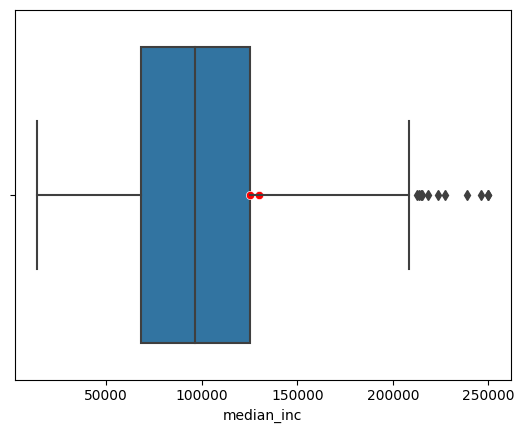

In [45]:
ax = sns.boxplot(cbg_income_2016_SJ, x='median_inc')
ax = sns.scatterplot(cbg_income_2016_SJ.loc[cbg_income_2016_SJ['GEOID'].isin(
    ['060855063014', '060855120291'])], x='median_inc', y=0, ax=ax, color='red')
#ax.axis('off')
plt.show()

## Counterfactual

In [112]:
cbg_income_2016_SJ.loc[cbg_income_2016_SJ['GEOID'].isin(
    ['060855063014', '060855120291'])]

,GEOID,median_inc,strata_inc,neighborho,geometry,median_inc_str
34,060855063014,125481.0,IS_37,high,"POLYGON ((-121.96067 37.31650, -121.96067 37.3...",125481.0
69,060855120291,130167.0,IS_39,high,"POLYGON ((-121.83084 37.25129, -121.83049 37.2...",130167.0


In [118]:
new_sbuild_cf = new_sbuild_2020_cbg.copy()
new_sbuild_cf['neighborhood_counterfactual'] = new_sbuild_cf['median_inc'].apply(
    lambda inc: 'Low' if inc <= 130167.0 else 'High')

In [119]:
new_sbuild_cf.groupby('neighborhood_counterfactual')[[
    'count_new_sbuild_permitted', 'count_new_sbuild']].sum().reset_index()

,neighborhood_counterfactual,count_new_sbuild_permitted,count_new_sbuild
0,High,2.0,13
1,Low,6.0,91


## Using parcel-level "income"

In [93]:
assessor_data_dict = {}

# Historic assessor data
assessor_data = assessor_historical.copy()

# * Filter to SJ
assessor_data = assessor_data.loc[assessor_data['SITUS CITY'] == 'SAN JOSE']
assessor_data = assessor_data[[
    'APN (PARCEL NUMBER UNFORMATTED)', 'FORMATTED APN', 'ORIGINAL APN', 
    'TOTAL VALUE CALCULATED', 'SITUS CITY']]
# * Most APNs are correctly 8-digit numbers 
assessor_data['APN'] = assessor_data['APN (PARCEL NUMBER UNFORMATTED)'].apply(
    lambda apn: apn)
assessor_data['apn_len'] = assessor_data['APN (PARCEL NUMBER UNFORMATTED)'].apply(
    lambda apn: len(apn))

# * Filter to residential parcels
assessor_data = assessor_data.loc[assessor_data['APN'].isin(sj_parcels_cbgs['APN'].unique())]
assessor_data['parcel_income'] = assessor_data['TOTAL VALUE CALCULATED']
assessor_data_dict['historic'] = assessor_data[['APN', 'parcel_income']].copy()

# Latest assessor data
assessor_data = sj_assessor_parcels.copy()
assessor_data['parcel_income'] = assessor_data['LAND'] + assessor_data['IMPROVEMEN']
assessor_data_dict['latest'] = assessor_data[['APN', 'parcel_income']].copy()

In [94]:
# Divide parcel-level "income" into quartiles
quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

parcel_inc_dict = {}
for time_period in assessor_data_dict.keys():
    assessor_data = assessor_data_dict[time_period].copy()
    assessor_data['parcel_quartile'] = pd.qcut(
        assessor_data['parcel_income'], q=4, 
        labels=['IS_{}'.format(i) for i in range(4)])

    assessor_data['parcel_quartile'] = assessor_data['parcel_quartile'].apply(
        lambda quartile: quartile_names[quartile])
    assessor_data_dict[time_period] = assessor_data.copy()
    
    # Assign parcel-level income group
    new_sbuild_parcel_inc = new_sbuild_parcel.copy()

    new_sbuild_parcel_inc = pd.merge(
        new_sbuild_parcel_inc, assessor_data[['APN', 'parcel_income', 'parcel_quartile']],
        how='left', validate='many_to_one')

    print('[INFO] Number of parcels without {} assessor data: {}'.format(
        time_period, new_sbuild_parcel_inc['parcel_income'].isna().sum()))
    parcel_inc_dict[time_period] = new_sbuild_parcel_inc.copy()

[INFO] Number of parcels without historic assessor data: 1
[INFO] Number of parcels without latest assessor data: 0


In [95]:
pd.qcut(assessor_data_dict['historic']['parcel_income'], q=4).unique()

[(629997.0, 36808485.0], (201684.0, 388951.0], (5.999, 201684.0], (388951.0, 629997.0], NaN]
Categories (4, interval[float64, right]): [(5.999, 201684.0] < (201684.0, 388951.0] < (388951.0, 629997.0] < (629997.0, 36808485.0]]

In [119]:
time_period = ['historic', 'latest'][0]

try:
    assessor_data = assessor_data_dict[time_period].copy()
    print('[INFO] Number of residential parcels in {} assessor data: {}'.format(
        time_period, len(assessor_data)))
    new_sbuild_parcel_inc = parcel_inc_dict[time_period].copy()
except KeyError:
    raise Exception('[ERROR] Check assessor data type')

[INFO] Number of residential parcels in historic assessor data: 156987


In [120]:
new_sbuild_parcel_inc.loc[new_sbuild_parcel_inc['parcel_income'].isna()]

,APN,GEOID,median_inc,quartile,Permitted,parcel_income,parcel_quartile
8,01511081,060855046021,77734.0,Low-Moderate,0,NaN,NaN


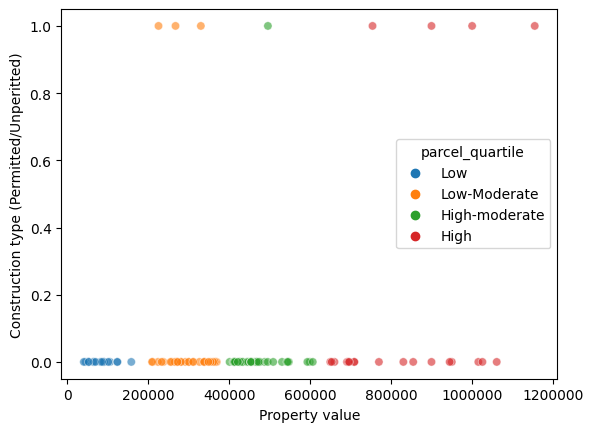

In [121]:
ax = sns.scatterplot(new_sbuild_parcel_inc, x='parcel_income', y='Permitted', hue='parcel_quartile', alpha=0.6)
ax.set(xlabel='Property value', ylabel='Construction type (Permitted/Unperitted)')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [122]:
outcome = new_sbuild_parcel_inc.groupby('parcel_quartile').agg(
    {'Permitted': 'sum', 'APN': 'count'}).reset_index()
outcome['permitted_prop'] = outcome['Permitted'] / outcome['APN']

In [123]:
outcome

,parcel_quartile,Permitted,APN,permitted_prop
0,Low,0,18,0.000000
1,Low-Moderate,3,31,0.096774
2,High-moderate,1,33,0.030303
3,High,4,21,0.190476


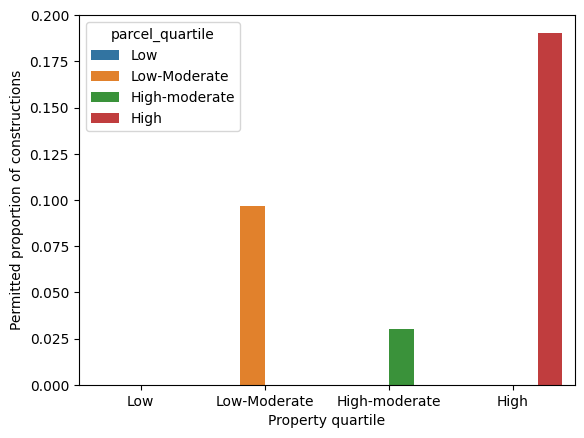

In [124]:
ax = sns.barplot(outcome, x='parcel_quartile', y='permitted_prop', hue='parcel_quartile')
ax.set(xlabel='Property quartile', ylabel='Permitted proportion of constructions')
plt.show()

In [125]:
# Bottom 3 quartiles vs top quartile
low = outcome.loc[outcome['parcel_quartile'].isin(['Low', 'Low-Moderate', 'High-moderate'])]
high = outcome.loc[outcome['parcel_quartile'] == 'High']
baseline = low['Permitted'].sum() / low['APN'].sum() * 100
high_level = high['Permitted'].sum() / high['APN'].sum() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 4.9; Effect size: 14.2


In [85]:
# Median
low = outcome.loc[outcome['parcel_quartile'].isin(['Low', 'Low-Moderate'])]
high = outcome.loc[outcome['parcel_quartile'].isin(['High-moderate', 'High'])]
baseline = low['Permitted'].sum() / low['APN'].sum() * 100
high_level = high['Permitted'].sum() / high['APN'].sum() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 6.1; Effect size: 3.1


In [87]:
# Bottom vs upper quartiles
low = outcome.loc[outcome['parcel_quartile'].isin(['Low'])]
high = outcome.loc[outcome['parcel_quartile'].isin(['High'])]
baseline = low['Permitted'].sum() / low['APN'].sum() * 100
high_level = high['Permitted'].sum() / high['APN'].sum() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 0.0; Effect size: 19.0


## Construction events

In [108]:
parcel_geom = sj_parcels_cbgs.copy()
parcel_geom['centroid'] = parcel_geom.to_crs('EPSG:26910').geometry.centroid
parcel_geom = gpd.GeoDataFrame(parcel_geom[['APN', 'centroid']], geometry='centroid', crs='EPSG:26910')
parcel_geom = parcel_geom.to_crs('EPSG:4326')
parcel_geom['coords'] = parcel_geom['centroid'].apply(
    lambda c: '{}, {}'.format(list(c.coords)[0][1], list(c.coords)[0][0]))

In [114]:
# Low income events
low_events = new_sbuild_parcel_inc.loc[new_sbuild_parcel_inc['parcel_quartile'] != 'High']
low_events = low_events.merge(parcel_geom[['APN', 'coords']], validate='many_to_one')

In [115]:
# High income events
high_events = new_sbuild_parcel_inc.loc[new_sbuild_parcel_inc['parcel_quartile'] == 'High']
high_events = high_events.merge(parcel_geom[['APN', 'coords']], validate='many_to_one')

In [126]:
low_events.tail(10)

,APN,GEOID,median_inc,quartile,Permitted,parcel_income,parcel_quartile,coords
73,67849070,060855120393,119348.0,High-moderate,0,545198.0,High-moderate,"37.24595641165711, -121.77929527969044"
74,68432012,060855120432,85156.0,Low-Moderate,0,158178.0,Low,"37.26553910022802, -121.80972039052048"
75,68433070,060855120432,85156.0,Low-Moderate,0,421292.0,High-moderate,"37.26634802571772, -121.80744013865008"
76,68701028,060855120471,99792.0,High-moderate,0,310691.0,Low-Moderate,"37.248039869891514, -121.84046360025593"
77,68918083,060855120372,110917.0,High-moderate,0,348727.0,Low-Moderate,"37.24293667218261, -121.82543410673058"
78,68922029,060855120361,102200.0,High-moderate,0,85909.0,Low,"37.23789860076776, -121.8095280779002"
79,69205043,060855120294,131458.0,High,0,453110.0,High-moderate,"37.24408107003004, -121.8099754074092"
80,69501022,060855120533,99620.0,High-moderate,0,453788.0,High-moderate,"37.23992865681753, -121.86176072202376"
81,69501022,060855120533,99620.0,High-moderate,0,453788.0,High-moderate,"37.23992865681753, -121.86176072202376"
82,70617022,060855120352,120543.0,High-moderate,0,472612.0,High-moderate,"37.228957098640954, -121.76325373303983"


In [117]:
high_events

,APN,GEOID,median_inc,quartile,Permitted,parcel_income,parcel_quartile,coords
0,26462005,060855023022,92308.0,Low-Moderate,1,899596.0,High,"37.31035389146982, -121.91122654787188"
1,26462005,060855023022,92308.0,Low-Moderate,0,899596.0,High,"37.31035389146982, -121.91122654787188"
2,44626011,060855025006,158819.0,High,1,1154619.0,High,"37.29015939405202, -121.90321756158087"
3,49724012,060855032045,57750.0,Low,1,754000.0,High,"37.29246305776481, -121.84196957732348"
4,70101032,060855119072,157652.0,High,1,1000000.0,High,"37.221001411259344, -121.8605999704485"
5,24953062,060855011022,51944.0,Low,0,659912.0,High,"37.34955991475111, -121.88410140161066"
6,30334023,060855063014,125481.0,High,0,830126.0,High,"37.321169723140684, -121.95711238898645"
7,37317034,060855079064,198750.0,High,0,690864.0,High,"37.299607919245744, -122.02291959256912"
8,43428123,060855024005,113819.0,High-moderate,0,949750.0,High,"37.306610959574314, -121.88422716258431"
9,43909051,060855025004,151550.0,High,0,1015294.0,High,"37.29438517935357, -121.89154290221097"


## Comparison of parcels

In [75]:
# We drop duplicate parcels as they have the same quartile anyway
visual_parcels = parcel_inc_dict['historic'].copy()
visual_parcels.drop_duplicates(subset=['APN'], inplace=True)

neighborhood_names = {'Low': 'Low', 'Low-Moderate': 'Low', 'High-moderate': 'Low', 'High': 'High'}

visual_parcels['neighborhood_parcel'] = visual_parcels['parcel_quartile'].apply(
    lambda quart: neighborhood_names[quart])

visual_parcels['neighborhood_CBG'] = visual_parcels['quartile'].apply(
    lambda quart: neighborhood_names[quart])

#visual_parcels = visual_parcels[['APN', 'parcel_quartile']]
#visual_parcels.rename(columns={'parcel_quartile': 'parcel_quartile_historic'}, inplace=True)

#visual_parcels_latest = parcel_inc_dict['latest'][['APN', 'parcel_quartile']].copy()
#visual_parcels_latest.drop_duplicates(subset=['APN'], inplace=True)


#visual_parcels = pd.merge(
#    visual_parcels, visual_parcels_latest, validate='one_to_one')
#visual_parcels.rename(columns={'parcel_quartile': 'parcel_quartile_latest'}, inplace=True)

In [78]:
x = visual_parcels.loc[visual_parcels['neighborhood_parcel'] != visual_parcels['neighborhood_CBG']]

In [81]:
x[['APN', 'neighborhood_parcel', 'neighborhood_CBG']]

,APN,neighborhood_parcel,neighborhood_CBG
1,26462005,High,Low
2,30341002,Low,High
5,49724012,High,Low
6,69226014,Low,High
8,01511081,NaN,Low
16,24953062,High,Low
19,26123040,Low,High
22,27409002,Low,High
23,27453041,Low,High
31,42914030,Low,High


## Assessor data

In [7]:
assessor_historical = assessor_historical.loc[assessor_historical['SITUS CITY'] == 'SAN JOSE']
assessor_historical['APN'] = assessor_historical['APN (PARCEL NUMBER UNFORMATTED)'].apply(
    lambda apn: apn)
# * Filter to residential parcels
assessor_historical = assessor_historical.loc[assessor_historical[
    'APN'].isin(sj_parcels_cbgs['APN'].unique())]

In [8]:
assessor_historical_14 = assessor_historical_14.loc[assessor_historical_14['SITUS CITY'] == 'SAN JOSE']
assessor_historical_14['APN'] = assessor_historical_14['APN (PARCEL NUMBER UNFORMATTED)'].apply(
    lambda apn: apn)
# * Filter to residential parcels
assessor_historical_14 = assessor_historical_14.loc[assessor_historical_14[
    'APN'].isin(sj_parcels_cbgs['APN'].unique())]

In [11]:
# Merge to compute value change rate
assessor_historical_merged = assessor_historical[
    ['APN', 'TOTAL VALUE CALCULATED']].merge(
    assessor_historical_14[['APN', 'TOTAL VALUE CALCULATED']], on='APN', validate='one_to_one')

In [17]:
assessor_historical_merged['perc_change'] = (assessor_historical_merged['TOTAL VALUE CALCULATED_x'] / assessor_historical_merged['TOTAL VALUE CALCULATED_y'] - 1)* 100



In [35]:
((assessor_historical_merged['perc_change'] <= 3.6) & (assessor_historical_merged['perc_change'] >= 3.5)).mean()

0.8409444401948035

In [19]:
assessor_historical_merged['perc_change'].describe()

count    156286.000000
mean         25.142367
std         172.361411
min         -99.997896
25%           3.552408
50%           3.552958
75%           3.553223
max       39582.539683
Name: perc_change, dtype: float64

In [25]:
(assessor_historical_merged['perc_change'] > 100).sum()

5128

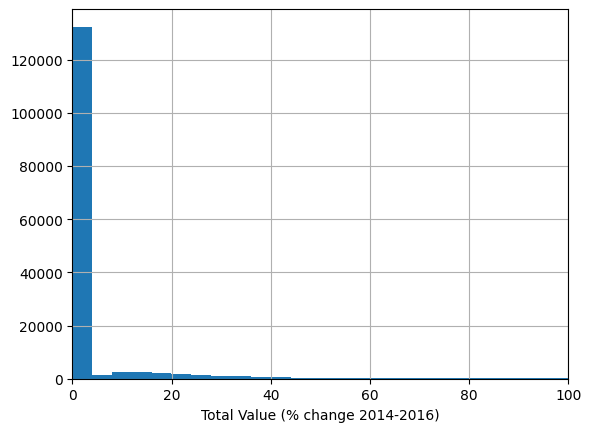

In [31]:
ax = assessor_historical_merged.loc[assessor_historical_merged['perc_change'] <= 100]['perc_change'].hist(bins=50)
ax.set_xlabel("Total Value (% change 2014-2016)")
plt.xlim(0, 100)
plt.show()

In [48]:
assessor_historical_14.iloc[10][31:42]

SITUS HOUSE NUMBER                  2040
SITUS HOUSE NUMBER SUFFIX            NaN
SITUS HOUSE NUMBER #2                NaN
SITUS DIRECTION                        N
SITUS STREET NAME                CAPITOL
SITUS MODE                           AVE
SITUS QUADRANT                       NaN
SITUS UNIT NUMBER                      1
SITUS CITY                      SAN JOSE
SITUS STATE                           CA
SITUS ZIP CODE               951321012.0
Name: 23726, dtype: object

In [49]:
assessor_historical_14.iloc[10][66:120]

TOTAL VALUE CALCULATED              773391.0
LAND VALUE CALCULATED               491208.0
IMPROVEMENT VALUE CALCULATED        282183.0
TOTAL VALUE CALCULATED IND                 A
LAND VALUE CALCULATED IND                  A
IMPROVEMENT VALUE CALCULATED IND           A
ASSD TOTAL VALUE                    773391.0
ASSD LAND VALUE                     491208.0
ASSD IMPROVEMENT VALUE              282183.0
MKT TOTAL VALUE                          NaN
MKT LAND VALUE                           NaN
MKT IMPROVEMENT VALUE                    NaN
APPR TOTAL VALUE                         NaN
APPR LAND VALUE                          NaN
APPR IMPROVEMENT VALUE                   NaN
TAX AMOUNT                          10917.22
TAX YEAR                              2014.0
ASSESSED YEAR                         2014.0
TAX CODE AREA                        17010.0
FRONT FOOTAGE                           60.0
DEPTH FOOTAGE                          104.0
ACRES                                  0.142
LAND SQUAR

In [43]:
assessor_historical.iloc[10][31:42]

SITUS HOUSE NUMBER                  2048
SITUS HOUSE NUMBER SUFFIX            NaN
SITUS HOUSE NUMBER #2                NaN
SITUS DIRECTION                        N
SITUS STREET NAME                CAPITOL
SITUS MODE                           AVE
SITUS QUADRANT                       NaN
SITUS UNIT NUMBER                      1
SITUS CITY                      SAN JOSE
SITUS STATE                           CA
SITUS ZIP CODE               951321014.0
Name: 24376, dtype: object

In [38]:
assessor_historical.iloc[10][66:120]

TOTAL VALUE CALCULATED              538472.0
LAND VALUE CALCULATED               210099.0
IMPROVEMENT VALUE CALCULATED        328373.0
TOTAL VALUE CALCULATED IND                 A
LAND VALUE CALCULATED IND                  A
IMPROVEMENT VALUE CALCULATED IND           A
ASSD TOTAL VALUE                    538472.0
ASSD LAND VALUE                     210099.0
ASSD IMPROVEMENT VALUE              328373.0
MKT TOTAL VALUE                          NaN
MKT LAND VALUE                           NaN
MKT IMPROVEMENT VALUE                    NaN
APPR TOTAL VALUE                         NaN
APPR LAND VALUE                          NaN
APPR IMPROVEMENT VALUE                   NaN
TAX AMOUNT                           8369.26
TAX YEAR                              2016.0
ASSESSED YEAR                         2016.0
TAX CODE AREA                          17010
FRONT FOOTAGE                           70.0
DEPTH FOOTAGE                          104.0
ACRES                                 0.1671
LAND SQUAR

In [51]:
assessor_historical_14['TOTAL VALUE CALCULATED'].mean()

402354.1011731143

In [50]:
assessor_historical['TOTAL VALUE CALCULATED'].mean()

453301.5021643361

In [53]:
assessor_historical_14['TOTAL VALUE CALCULATED'].median()

350926.0

In [52]:
assessor_historical['TOTAL VALUE CALCULATED'].median()

388951.0

In [65]:
453301 / 402354.1011731143 - 1

0.1266220443095858

In [75]:
assessor_parcels_sc = gpd.read_file(os.path.join(INPUT_FP, 'AssessorData', 'assessor_scc_parcels.geojson'))


In [76]:
assessor_parcels_sc = assessor_parcels_sc.loc[assessor_parcels_sc['FEATURE'] == 'PAR']
assessor_parcels_sc['parcel_income'] = assessor_parcels_sc['LAND'] + assessor_parcels_sc['IMPROVEMEN']

In [77]:
assessor_parcels_sc['parcel_income'].mean()

1130090.5025584698

In [78]:
assessor_parcels = gpd.read_file(os.path.join(INPUT_FP, 'AssessorData', 'assessor_scc_parcels.geojson'))
sj_assessor_parcels = assessor_parcels.loc[assessor_parcels['SITUS_CITY'] == 'SAN JOSE'].copy()
del assessor_parcels

# Keep only parcel data
sj_assessor_parcels = sj_assessor_parcels.loc[sj_assessor_parcels['FEATURE'] == 'PAR']

In [79]:
sj_assessor_parcels['parcel_income'] = sj_assessor_parcels['LAND'] + sj_assessor_parcels['IMPROVEMEN']

In [69]:
sj_assessor_parcels = sj_assessor_parcels.loc[sj_assessor_parcels[
    'APN'].isin(sj_parcels_cbgs['APN'].unique())]

In [80]:
# All parcels in SJ (228k)
sj_assessor_parcels['parcel_income'].mean()

848259.8041449824

In [74]:
# Our residential parcels
sj_assessor_parcels['parcel_income'].mean()

573095.4219410081

In [130]:
# Parcel distribution by CBG income
cbg_info = sj_parcels_cbgs.copy()
cbg_info = cbg_info.merge(cbg_income_2016_SJ[['GEOID', 'quartile']], validate='many_to_one')

In [134]:
# Add parcel data
cbg_info = cbg_info.merge(
    assessor_historical[['APN', 'TOTAL VALUE CALCULATED']], how='left', validate='one_to_one')

In [139]:
cbg_info.groupby('quartile')['TOTAL VALUE CALCULATED'].median()

quartile
Low              325913.0
Low-Moderate     337223.0
High-moderate    412282.5
High             516580.5
Name: TOTAL VALUE CALCULATED, dtype: float64

## Relationship between CBG and parcel-level income proxies

In [12]:
income = sj_parcels_cbgs.copy()
income = income.merge(cbg_income_2016_SJ[['GEOID', 'median_inc']], validate='many_to_one', how='left')

assessor_historical['APN'] = assessor_historical['APN (PARCEL NUMBER UNFORMATTED)'].apply(
    lambda apn: apn)

In [14]:
income = income.merge(
    assessor_historical[['APN', 'TOTAL VALUE CALCULATED']], validate='one_to_one', how='left')

In [21]:
income['CBG quartile'] = pd.qcut(income['median_inc'], q=4, 
    labels=['{}'.format(i) for i in range(4)])
income['Assessor quartile'] = pd.qcut(income['TOTAL VALUE CALCULATED'], q=4, 
    labels=['{}'.format(i) for i in range(4)])

In [24]:
pd.crosstab(income['CBG quartile'], income['Assessor quartile'])

Assessor quartile,0,1,2,3
CBG quartile,,,,
0,11424,12251,10191,5618
1,10189,11407,11048,6659
2,9157,9303,10205,11178
3,8761,6572,8075,16080


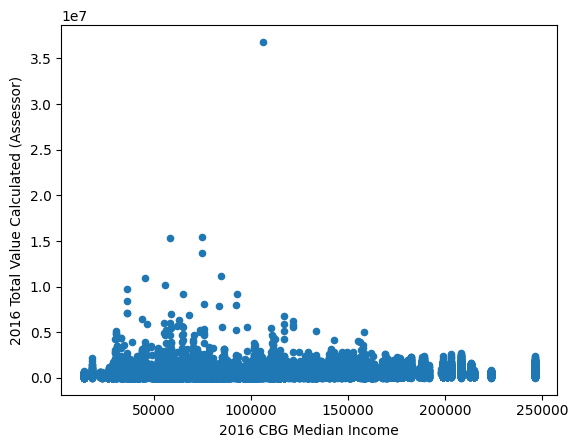

In [20]:
ax = income.plot.scatter(x='median_inc', y='TOTAL VALUE CALCULATED')
ax.set_xlabel("2016 CBG Median Income")
ax.set_ylabel("2016 Total Value Calculated (Assessor)")
plt.show()

## Fitting a logistic regression model

In [56]:
new_sbuild_parcel.to_csv(
    '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/misc/B1-construction-events/new_sbuild_parcel.csv', index=False)